In [4]:
%load_ext autoreload
%autoreload 2

In [274]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np


### Params

In [275]:
b,w,h = 2,20,20
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### MODEL

In [338]:
class Similarity(torch.nn.Module):
    """ Similarity based on sum of gaussian kernels of different strength and length_scales """

    def __init__(self, n_kernels: int = 4, eps: float = 1E-6):
        super().__init__()
        
        self.n_kernels = n_kernels
        self.eps = eps
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        self.w = torch.nn.Parameter(data=torch.randn(self.n_kernels, 
                                                     device=self.device, 
                                                     dtype=torch.float), requires_grad=True)
        self.b = torch.nn.Parameter(data=torch.randn(self.n_kernels, 
                                                     device=self.device, 
                                                     dtype=torch.float), requires_grad=True)
        
        
        # Initialization
        self.n_width = -1
        self.n_height = -1
        self.ix_grid = None
        self.iy_grid = None
        self.d2 = None
        self.diag = None 
        
        
    def compute_ixgrid_iygrid_d2_diag(self, n_width: int, n_height: int):
        with torch.no_grad():
            ix_array = torch.arange(start=0, end=n_width, dtype=torch.int, device=self.device)
            iy_array = torch.arange(start=0, end=n_height, dtype=torch.int, device=self.device)
            ix_grid, iy_grid = torch.meshgrid([ix_array, iy_array])
            pmap_points = torch.stack((ix_grid, iy_grid), dim=-1)  # n_width, n_height, 2
            tmp = pmap_points.flatten(start_dim=0, end_dim=-2)  # (n_width*n_height, 2)
            d2 = (tmp.unsqueeze(-2) - tmp.unsqueeze(-3)).pow(2).sum(dim=-1).float()
            diag = torch.eye(d2.shape[-2], 
                             dtype=torch.float, 
                             device=self.device, 
                             requires_grad=False) * self.eps
            return ix_grid, iy_grid, d2, diag
        
    
    def forward(self, n_width: int, n_height: int):
        """ Implement L = sum_i a_i exp[-b_i d2] """
        b = F.softplus(self.b).view(-1,1,1)
        w = F.softplus(self.w).view(-1,1,1)
        
        if (n_width != self.n_width) or (n_height != self.n_height):
            self.n_width=n_width
            self.n_height=n_height
            tmp = self.compute_ixgrid_iygrid_d2_diag(n_width=n_width, n_height=n_height)
            self.ix_grid, self.iy_grid, self.d2, self.diag = tmp
                    
        #likelihood_kernel = (w*torch.exp(-b*self.d2)).sum(dim=-3) + self.diag
        
        likelihood_kernel = torch.exp(-0.1*self.d2) + self.diag
        return likelihood_kernel  # shape (n_width*n_height, n_width*n_height)
    
    #def plot(self, sample):
    #    loc = torch.zeros(self.K.shape[-1])
    #    loc[sample] = 1
    #    loc.view()

In [339]:
class Dpp(object):
    
    def __init__(self, L=None):
        self.L = L
        print(self.L)
        lower = torch.cholesky(L)
        #debug1 = (torch.matmul(tmp,tmp.T)-L).abs().max()
        #print(debug1)
        
        d = torch.diagonal(lower, offset=0, dim1=-2, dim2=-1)
        self.L_eig_vals = d.pow(2)
        print(self.L_eig_vals)
        self.eig_vecs = lower/d
        #debug2 = (torch.matmul(self.eig_vecs*self.L_eig_vals, self.eig_vecs.T)-L).abs().max()
        #print(debug2)
        
        self.K_eig_vals = self.L_eig_vals / (1.0 + self.L_eig_vals)
        self.K = torch.matmul(self.eig_vecs * self.K_eig_vals, self.eig_vecs.T)
        print(self.K_eig_vals)
        print(self.K)
        
    def sample(self):
        A = self.L.clone()
        sample = []

        for j in range(len(A)):

            if torch.rand(1) < A[j, j]:
                sample.append(j)
            else:
                A[j, j] -= 1

            A[j + 1:, j] /= A[j, j]
            A[j + 1:, j + 1:] -= A[j + 1:, j].unsqueeze(-1)*A[j, j + 1:].unsqueeze(-2)

        return sample #, A
    


In [ ]:
PROBLEM. 
0. USE THE MODEL STRAIGHT FROM THE CODE AND SEE IF IT WORKS
1. MATRIX K is not translationally invariant...
2. SAMPLE ALWAYS PREFER THE FIRST LOCATION
3. Implement a nice plotting


In [340]:
similarity = Similarity()
L = similarity.forward(n_width=4, n_height=2)
print(L.shape)

torch.Size([8, 8])


In [342]:
dpp = Dpp(L=L)
#dpp.sample()

tensor([[1.0000, 0.9048, 0.9048, 0.8187, 0.6703, 0.6065, 0.4066, 0.3679],
        [0.9048, 1.0000, 0.8187, 0.9048, 0.6065, 0.6703, 0.3679, 0.4066],
        [0.9048, 0.8187, 1.0000, 0.9048, 0.9048, 0.8187, 0.6703, 0.6065],
        [0.8187, 0.9048, 0.9048, 1.0000, 0.8187, 0.9048, 0.6065, 0.6703],
        [0.6703, 0.6065, 0.9048, 0.8187, 1.0000, 0.9048, 0.9048, 0.8187],
        [0.6065, 0.6703, 0.8187, 0.9048, 0.9048, 1.0000, 0.8187, 0.9048],
        [0.4066, 0.3679, 0.6703, 0.6065, 0.9048, 0.8187, 1.0000, 0.9048],
        [0.3679, 0.4066, 0.6065, 0.6703, 0.8187, 0.9048, 0.9048, 1.0000]])
tensor([1.0000, 0.1813, 0.1813, 0.0329, 0.0598, 0.0108, 0.0270, 0.0049])
tensor([0.5000, 0.1535, 0.1535, 0.0318, 0.0564, 0.0107, 0.0263, 0.0049])
tensor([[0.5000, 0.4524, 0.4524, 0.4094, 0.3352, 0.3033, 0.2033, 0.1839],
        [0.4524, 0.5628, 0.4094, 0.5093, 0.3033, 0.3773, 0.1839, 0.2288],
        [0.4524, 0.4094, 0.5628, 0.5093, 0.5558, 0.5029, 0.4400, 0.3981],
        [0.4094, 0.5093, 0.5093, 0.6182

torch.Size([8, 8])


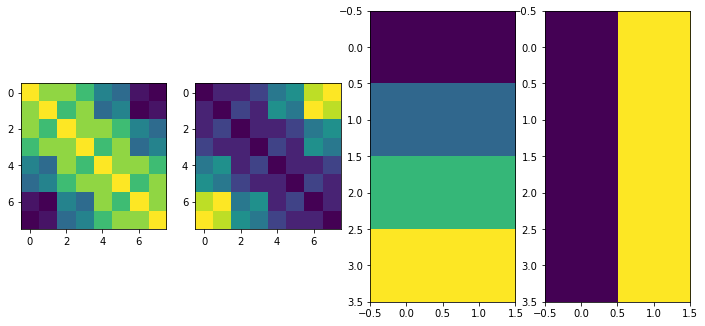

In [236]:
fig, ax =  plt.subplots(ncols=4, figsize=(12,12))
ax[0].imshow(L.detach().numpy())
ax[1].imshow(s.d2)
ax[2].imshow(s.ix_grid)
ax[3].imshow(s.iy_grid)

[1, 2, 5, 6]

In [186]:
def dpp_sampler_generic_kernel(K, random_state=None):
    """ Sample from generic :math:`\\operatorname{DPP}(\\mathbf{K})` with potentially non hermitian correlation kernel :math:`\\operatorname{DPP}(\\mathbf{K})` based on :math:`LU` factorization procedure.
    :param K:
        Correlation kernel (potentially non hermitian).
    :type K:
        array_like
    :return:
        A sample :math:`\\mathcal{X}` from :math:`\\operatorname{DPP}(K)` and
        the in-place :math:`LU factorization of :math:`K − I_{\\mathcal{X}^{c}}` where :math:`I_{\\mathcal{X}^{c}}` is the diagonal indicator matrix for the entries not in the sample :math:`\\mathcal{X}`.
    :rtype:
        list and array_like
    .. seealso::
        - :cite:`Pou19` Algorithm 1
    """

    A = K.clone()
    sample = []

    for j in range(len(A)):

        if torch.rand(1) < A[j, j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j + 1:, j] /= A[j, j]
        A[j + 1:, j + 1:] -= A[j + 1:, j]*A[j, j + 1:]

    return sample, A

In [187]:
dpp_sampler_generic_kernel(dpp.K)

([1, 2, 3, 5, 6],
 tensor([[-0.1922,  0.5003,  0.5003,  0.3194,  0.1415,  0.0976,  0.0257,  0.0189],
         [-2.6029,  2.3337,  1.6260,  1.1669,  0.2062,  0.2274,  0.0236,  0.0339],
         [-2.6029,  0.6967,  1.2010,  0.1977,  0.6659,  0.3411,  0.1880,  0.1187],
         [-1.6616,  0.8307,  0.6709,  0.7031, -0.0506,  0.5707,  0.0748,  0.1912],
         [-0.7361,  0.6018,  0.7121, -0.1816, -0.2857,  0.2735,  0.7528,  0.5372],
         [-0.5076,  0.6343,  0.5039,  0.3784, -0.8849,  1.2316,  1.1969,  0.9564],
         [-0.1338,  0.5667,  0.3059, -0.6101, -0.9498,  0.2136,  1.7250,  0.2931],
         [-0.0982,  0.5718,  0.2545, -0.4725,  0.0307,  0.5600,  0.7189, -0.1762]],
        grad_fn=<CopySlices>))

In [145]:
dpp = Dpp(similarity=L)

tensor(2.3842e-07, grad_fn=<MaxBackward1>)
tensor(2.3842e-07, grad_fn=<MaxBackward1>)


In [146]:
dpp.sample()

tensor([1.6907, 1.3997, 1.3958, 1.2219, 1.3786, 1.2081, 1.3742, 1.2052],
       grad_fn=<DiagonalBackward>)
tensor([0.4274, 0.5954, 0.7741, 0.6738, 0.0093, 0.0381, 0.6485, 0.4944])
tensor([False,  True,  True,  True, False, False,  True, False])


In [110]:
a = torch.arange(9).view(3,3).float()
print(a)
print(a.T)

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
tensor([[0., 3., 6.],
        [1., 4., 7.],
        [2., 5., 8.]])


### GUIDE

In [ ]:


logit = torch.randn((b,1,w,h))
pb = pass_bernoulli(logit=logit)

c = pb.sample()
log_p = pb.log_prob(c)
